In [6]:
#!/usr/bin/env python
# coding: utf-8
import os
import gc
import sys
import time 
import random
import logging 
import warnings
import numpy as np
import pandas as pd 
import rasterio as rio
import scipy.io as sio
import geopandas as gpd
from ctypes import c_double
from shapely.wkt import loads
from shapely.geometry import Point
import scipy.spatial.distance
### user
import haversine as haversine
from queue_class import Network, Node, Link, Agent

random.seed(0)
np.random.seed(0)

# warnings.filterwarnings("error")

def link_model(t, network):

    for link_id, link in network.links.items(): 
        link.run_link_model(t, agent_id_dict=network.agents)
#         print(link.link_type)
        if link.link_type == 'v': ### do not track the link time of virtual links
            link.travel_time_list = []
        else:
            link.travel_time_list = []
        # link.update_travel_time(self, t_now, link_time_lookback_freq=None, g=None, update_graph=False)
    return network

def node_model(t, network, move, check_traffic_flow_links_dict):
    node_ids_to_run = set([link.end_nid for link in network.links.values() if len(link.queue_vehicles)>0])
    metrics = 0 
    for node_id in node_ids_to_run:
        node = network.nodes[node_id] 
        n_t_move, transfer_links, agent_update_dict, link_update_dict = node.run_node_model(t, node_id_dict=network.nodes, link_id_dict=network.links, agent_id_dict=network.agents, node2link_dict=network.node2link_dict)
        move += n_t_move
        ### how many people moves across a specified link pair in this step
        for transfer_link in transfer_links:
            if transfer_link in check_traffic_flow_links_dict.keys():
                check_traffic_flow_links_dict[transfer_link] += 1
    
        for agent_id, agent_new_info in agent_update_dict.items():
            
            if agent_new_info[0] == 'shelter_p': metrics += 1
            ### move stopped vehicles to a separate dictionary
            if agent_new_info[0] in ['shelter_arrive', 'arrive']:
                network.agents_stopped[agent_id] = agent_new_info
                del network.agents[agent_id]
            ### update vehicles still not stopped
            else:
                agent = network.agents[agent_id]
                [agent.status, agent.current_link_start_nid, agent.current_link_end_nid,  agent.current_link_enter_time] = agent_new_info
                agent.find_next_link(t, node2link_dict = network.node2link_dict)

        for link_id, link_new_info in link_update_dict.items():
            if link_new_info[0] == 'inflow':
                [_, network.links[link_id].queue_vehicles, 
                network.links[link_id].remaining_outflow_capacity, 
                network.links[link_id].travel_time_list] = link_new_info
            elif link_new_info[0] == 'outflow':
                [_, network.links[link_id].run_vehicles, 
                network.links[link_id].remaining_inflow_capacity,
                network.links[link_id].remaining_storage_capacity] = link_new_info
            else:
                print('invalid link update information')
        
    return network, move, check_traffic_flow_links_dict,metrics

def one_step(t, network, check_traffic_flow_links, scen_nm, simulation_outputs):
    
    move = 0
    ### agent model
    t_agent_0 = time.time()
    for agent_id, agent in network.agents.items():
        # initial route 
        if t==0: routing_status = agent.get_path(g=network.g)
        agent.load_vehicle(t, node2link_dict=network.node2link_dict, link_id_dict=network.links)
        # reroute upon closure
        if (agent.next_link is not None) and (network.links[agent.next_link].status=='closed'):
            routing_status = agent.get_path(g=network.g)
            agent.find_next_link(t, node2link_dict=network.node2link_dict)
    t_agent_1 = time.time()

    ### link model
    ### Each iteration in the link model is not time-consuming. So just keep using one process.
    t_link_0 = time.time()
    network = link_model(t, network)
    t_link_1 = time.time()
    
    ### node model
    t_node_0 = time.time()
    check_traffic_flow_links_dict = {link_pair: 0 for link_pair in check_traffic_flow_links}
    network, move, check_traffic_flow_links_dict,metric = node_model(t, network, move, check_traffic_flow_links_dict)
    t_node_1 = time.time()

    ### metrics
    if t%1 == 0:
#         shelter_p_cnts = len([agent_id for agent_id, agent_info in network.agents_stopped.items() if agent_info[0]=='shelter_p'])
        arrival_cnts = len([agent_id for agent_id, agent_info in network.agents_stopped.items() if agent_info[0]=='arrive'])
        shelter_cnts = len([agent_id for agent_id, agent_info in network.agents_stopped.items() if agent_info[0]=='shelter_arrive'])
        if len(network.agents)==0:
            logging.info("all agents arrive at destinations")
            return 0
        # vehicle locations
        veh_loc = [network.links[network.node2link_dict[(agent.current_link_start_nid, agent.current_link_end_nid)]].midpoint for agent in network.agents.values()]
        ### arrival
        with open(simulation_outputs + '/t_stats/t_stats_{}.csv'.format(scen_nm),'a') as t_stats_outfile:
            t_stats_outfile.write(",".join([str(x) for x in [t, arrival_cnts, shelter_cnts, move, metric]]) + "\n")
        ### transfer
        with open(simulation_outputs + '/transfer_stats/transfer_stats_{}.csv'.format(scen_nm), 'a') as transfer_stats_outfile:
            transfer_stats_outfile.write("{},".format(t) + ",".join([str(check_traffic_flow_links_dict[(il, ol)]) for (il, ol) in check_traffic_flow_links])+"\n")

    ### stepped outputs
    if t%1==0:
        link_output = pd.DataFrame(
            [(link.link_id, len(link.queue_vehicles), len(link.run_vehicles), round(link.travel_time, 2)) for link in network.links.values() if not link.link_type=='v'], columns=['link_id', 'q', 'r', 't'])
        link_output.to_csv(simulation_outputs + '/link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t), index=False)
        node_agent_cnts = pd.DataFrame(
            [(agent.current_link_end_nid, agent.status, 1) for agent in network.agents.values()], columns=['node_id', 'status', 'cnt']).groupby(['node_id', 'status']).agg({'cnt': np.sum}).reset_index()
        node_agent_cnts.to_csv(simulation_outputs + '/node_stats/node_agent_cnts_{}_t{}.csv'.format(scen_nm, t), index=False)

    if t%200==0: 
        logging.info(" ".join([str(i) for i in [t, arrival_cnts, shelter_cnts, move, '|', round(t_agent_1-t_agent_0, 2), round(t_node_1-t_node_0, 2), round(t_link_1-t_link_0, 2)]]) + " " + str(len(veh_loc)))
    return network

def demand(dept_time=[0,0,0,1000], demand_files=None, fire_dir = 'north', speed = 25):
    logger = logging.getLogger("bk_evac")
    direction = {'south': 8398747289,
    'north': 2006817311,
    'east': 2882876550,
    'west': 110377352 }
    direction_opp ={'north':'south', 'south': 'north', 'east': 'west', 'west': 'east'}

    all_od_list = []
    [dept_time_mean, dept_time_std, dept_time_min, dept_time_max] = dept_time
    # demand_files = ['/projects/berkeley_trb/demand_inputs/od_test.csv']
#     for demand_file in demand_files:
    od = pd.read_csv('../woodacre_civic'+ demand_files)
#         ### transform OSM based id to graph node id
#         od['origin_nid'] = od['o_osmid'].apply(lambda x: nodes_osmid_dict[x])
#         od['destin_nid'] = od['d_osmid'].apply(lambda x: nodes_osmid_dict[x])
    ### assign agent id
#         if 'agent_id' not in od.columns: od['agent_id'] = np.arange(od.shape[0])
    ### assign departure time. dept_time_std == 0 --> everyone leaves at the same time
    if (dept_time_std==0): od['dept_time'] = dept_time_mean
    else:
        truncnorm_a, truncnorm_b = (dept_time_min-dept_time_mean)/dept_time_std, (dept_time_max-dept_time_mean)/dept_time_std
        od['dept_time'] = truncnorm.rvs(truncnorm_a, truncnorm_b, loc=dept_time_mean, scale=dept_time_std, size=od.shape[0])
        od['dept_time'] = od['dept_time'].astype(int)
        # od.to_csv(scratch_dir + '/od.csv', index=False)
        # sys.exit(0)
    od['destin_osmid'] = int(direction[direction_opp[fire_dir]])

#     if phase_tdiff is not None:
#         od['dept_time'] += (od['evac_zone']-1)*phase_tdiff*60 ### t_diff in minutes
    od.to_csv('../woodacre_civic' + demand_files, index=False)

        # od['dept_time'] = 0
#         ### assign vehicle length
#         od_tow = od.groupby(['apn', 'hh']).agg({'hh_veh': 'first'}).sample(frac=tow_pct).reset_index()
#         od_tow['veh_len'] = 15
#         od = od.merge(od_tow, how='left', on=['apn', 'hh', 'hh_veh']).fillna(value={'veh_len': 8})
#         # print(od.drop_duplicates(subset=['apn']).shape, od.drop_duplicates(subset=['apn', 'hh']).shape, od.drop_duplicates(subset=['apn', 'hh', 'hh_veh']).shape, np.sum(od['veh_len']==8), np.sum(od['veh_len']==15))
#         # sys.exit(0)
#         ### assign rerouting choice
#         od['gps_reroute'] = np.random.choice([0, 1], size=od.shape[0], p=[1-reroute_pct, reroute_pct])
#         all_od_list.append(od)

#     all_od = pd.concat(all_od_list, sort=False, ignore_index=True)
#     all_od = all_od.sample(frac=1).reset_index(drop=True) ### randomly shuffle rows
#     logging.info('total numbers of agents from file {}'.format(all_od.shape))
#     # all_od = all_od.iloc[0:3000].copy()
#     logging.info('total numbers of agents taken {}'.format(all_od.shape))

#     agents = []
#     for row in all_od.itertuples():
#         agents.append(Agent(getattr(row, 'agent_id'), getattr(row, 'origin_nid'), getattr(row, 'destin_nid'), getattr(row, 'dept_time'), getattr(row, 'veh_len'), getattr(row, 'gps_reroute')))    
#     return agents
      

def preparation(dept_time_col=None, dept_time_id = 'imm'):
    ### logging and global variables
    
    dept_time_dict = {'imm': [0,0,0,1000], 'fst': [20*60,10*60,10*60,30*60], 'mid': [40*60,20*60,20*60,60*60], 'slw': [60*60,30*60,30*60,90*60]}
    dept_time = dept_time_dict[dept_time_id]
    
    
   
    reroute_freq = 10 ### sec
    link_time_lookback_freq = 20 ### sec
    ### dir
#     work_dir = os.environ['HOME']+'/Documents/spatial_queue/example'
    network_file_edges = '/network_inputs/osm_edges_woodacre.csv'
    network_file_nodes = '/network_inputs/osm_nodes_woodacre.csv'
    demand_files = ["/demand_inputs/od_csv/od.csv"]
    simulation_outputs = '../woodacre_civic/simulation_outputs' ### scratch_folder

    demand(dept_time=[0,0,0,1000], demand_files=demand_files[0], fire_dir = 'north', speed = 25)
    scen_nm = "test"
    logging.basicConfig(filename=simulation_outputs+'/log/{}.log'.format(scen_nm), filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO, force=True)
    logging.info(scen_nm)
    print('log file created')

    ### network
    network = Network()
    network.dataframe_to_network(network_file_edges = network_file_edges, network_file_nodes = network_file_nodes)
    network.add_connectivity()

    ### demand
    network.add_demand(demand_files = demand_files)
    logging.info('total numbers of agents taken {}'.format(len(network.agents.keys())))
    
    ### time step output
    with open(simulation_outputs + '/t_stats/t_stats_{}.csv'.format(scen_nm), 'w') as t_stats_outfile:
        t_stats_outfile.write(",".join(['t', 'arr', 'shelter', 'move'])+"\n")
    ### track the traffic flow from the following link pairs
    check_traffic_flow_links = [(29,33)]
#     with open(simulation_outputs + '/transfer_stats/transfer_stats_{}.csv'.format(
#         scen_nm), 'w') as transfer_stats_outfile:
#         transfer_stats_outfile.write("t,"+",".join(['{}-{}'.format(il, ol) for (il, ol) in check_traffic_flow_links])+"\n")

    return network, check_traffic_flow_links, scen_nm, simulation_outputs


network, check_traffic_flow_links, scen_nm, simulation_outputs = preparation(dept_time_col='dept_time_scen_1')
# print(network.links)
for t in range(0, 3600+1):
#     print(t)
    network = one_step(t, network, check_traffic_flow_links, scen_nm, simulation_outputs)

# if __name__ == "__main__":
#     main(dept_time_col='dept_time_scen_1')

log file created


FileNotFoundError: [Errno 2] No such file or directory: '/network_inputs/osm_nodes_woodacre.csv'

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

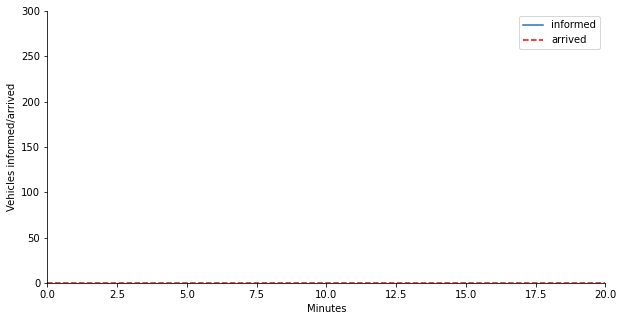

In [14]:

fig, ax = plt.subplots(figsize=(10, 5))
colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# for commscen in [0, 1, 2]:
#     c = next(colors)
#     ### residents informed
od = pd.read_csv('../woodacre_civic/demand_inputs/od_csv/od.csv')
od_cnts_t = od.groupby('dept_time').size().reset_index().rename(columns={0: 'od_cnts'})
od_cnts_t['tot_od_cnts'] = od_cnts_t['od_cnts'].cumsum()
od_cnts_t.head()
plt.plot([0], [300], label='informed')
### arrival
t_stats = pd.read_csv('../woodacre_civic/simulation_outputs/t_stats/t_stats_test.csv')
plt.plot(t_stats['t'], t_stats['arr'], color='red', linestyle='--', label='arrived')

plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlim([0, 20])
plt.ylim([0, 300])
plt.xlabel('Minutes')
plt.ylabel('Vehicles informed/arrived')
plt.legend()
plt.show()

In [23]:
t_stats = pd.read_csv('../woodacre_civic/simulation_outputs/t_stats/t_stats_test.csv')
t_stats.head()

,t,arr,shelter,move
0,0,0,0,0
1,100,0,143,0
2,200,0,149,0
3,261,0,98,0
4,261,0,32,0


In [4]:
od_cnts_t.head()

,dept_time,od_cnts,tot_od_cnts
0,0,2462,2462


In [5]:
import scipy.io as sio
import json
import sys
import numpy as np 
import pandas as pd 
import geopandas as gpd
import os 
import random
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.colors as pltcolors
import descartes 
import shapely.wkt 
import shapely.ops
import gc 
%matplotlib inline

absolute_path = '../woodacre_civic'

network_file_edges = '/network_inputs/osm_edges.csv'
simulation_outputs = '/simulation_outputs/link_stats'
visualization_outputs = '/visualization_outputs'

In [6]:
def make_img(t=0, memory=None):

    ### Get edge veh counts
    links_df = pd.read_csv('../woodacre_civic/network_inputs/osm_edges_woodacre.csv')
    link_queue_duration = pd.read_csv(absolute_path + simulation_outputs +'/link_stats_test_t{}.csv'.format(t))
    link_queue_duration = pd.merge(link_queue_duration, links_df[['eid', 'geometry']], left_on='link_id', right_on='eid', how='left')
    
#     road_df = pd.read_csv(absolute_path + network_file_edges)
#     veh_df = pd.read_csv(absolute_path + simulation_outputs +'link_queue_duration_{}.csv'.format(t))
    
    road_gdf = gpd.GeoDataFrame(link_queue_duration, 
        crs={'init': 'epsg:4326'}, 
        geometry=link_queue_duration['geometry'].map(shapely.wkt.loads))
#     print(road_gdf.head())
#     road_gdf = road_gdf.cx[-122.274061:-122.270398, 37.888713:37.890615]
    
#     veh_gdf = gpd.GeoDataFrame(veh_df, 
#                                crs={'init': 'epsg:4326'},
#                                geometry=gpd.points_from_xy(veh_df.lon, veh_df.lat))
#     veh_gdf = veh_gdf.cx[-122.274061:-122.270398, 37.888713:37.890615]
#     r = lambda: random.randint(0,255)
    
#     def id_to_random_color(number, memory):
#         if not number in memory:
#             hexcolor = '#%02X%02X%02X' % (r(),r(),r())
#             memory[number] = hexcolor
#         return memory[number]
    
#     veh_gdf['color'] = veh_gdf.apply(lambda x: id_to_random_color(x['v_id'], memory), axis=1)

    fig = plt.figure(figsize=(10, 10))
    
    ax1 = fig.add_axes([0.05, 0, 0.9, 0.9])
#     ax1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    road_plot = road_gdf.plot(ax=ax1, column='q')
#     veh_plot = veh_gdf.plot(ax=ax1, color=link_queue_duration['q'])

    fig.text(0.5, 0.85, '{} sec into evacuation'.format(t), fontsize=30, ha='center', va='center')
#     plt.show()
    # sys.exit(0)
    plt.savefig(absolute_path + visualization_outputs + 'veh_loc_t{}.png'.format(t), transparent=True)
    plt.close()
    
    return memory

In [97]:
make_img(t=1000, memory=None)

   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [99]:
def make_gif(memory=None):

    import imageio

    images = []
    for t in range(0,200, 2):
#         print(t)
        memory = make_img(t=t, memory=memory)
        images.append(imageio.imread(absolute_path + visualization_outputs + 'veh_loc_t{}.png'.format(t)))
    imageio.mimsave('../woodacre_civic/visualization_outputs/veh_loc_animation.gif', images, fps=2)

In [100]:
make_gif(memory=None)

/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  0  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  0  1  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                         

/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                         

/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...
   link_id  q  r     t  eid                                           geometry
0        0  1  0  4.58    0  LINESTRING (-122.64457 38.01290, -122.64515 38...
1        1  0  0  2.79    1  LINESTRING (-122.64457 38.01290, -122.64421 38...
2        2  0  0  3.70    2  LINESTRING (-122.64341 38.01206, -122.64315 38...
3        3  0  0  5.56    3  LINESTRING (-122.64341 38.01206, -122.64321 38...
4        4  0  0  3.87    4  LINESTRING (-122.64341 38.01206, -122.64343 38...


In [ ]:
links_df = pd.read_csv('../woodacre_civic/network_inputs/osm_edges.csv')
link_queue_duration = pd.read_csv('../woodacre_civic/simulation_outputs/link_stats/link_queue_duration_1000.csv')
link_queue_duration = pd.merge(link_queue_duration, links_df[['eid', 'geometry']], left_on='link_id', right_on='eid', how='left')
# link_queue_duration.head()
# link_queue_duration.to_csv('projects/bolinas_stinson_beach/visualization_outputs/link_queue_duration/link_queue_duration_1000.csv', index=False)

In [26]:
import sys
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
print(sys.executable)

/Users/barkha/opt/anaconda3/envs/capstone/bin/python


In [27]:
absolute_path = '/Users/barkha/Documents/UCB/Spring 2021/Capstone/Capstone/projects/woodacre_civic'
network_file_edges = '/network_inputs/osm_edges_woodacre.csv'
network_file_nodes = '/network_inputs/osm_nodes_woodacre.csv'
simulation_outputs = '/simulation_outputs/link_stats'
visualization_outputs = '/static/images/'

<AxesSubplot:>

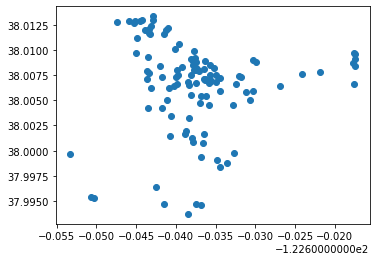

In [31]:
links_nodes = pd.read_csv(absolute_path + network_file_nodes)
# from shapely import wkt

links_nodes['geometry'] = links_nodes['geometry'].apply(loads)
gdf = gpd.GeoDataFrame(links_nodes, crs='epsg:4326')
gdf.plot()

In [38]:
def make_img(t=0, memory=None):
    
    ### Get edge veh counts
    links_nodes = pd.read_csv(absolute_path + network_file_nodes)
    links_df = pd.read_csv(absolute_path + network_file_edges)
    link_queue_duration = pd.read_csv(absolute_path + simulation_outputs + '/link_stats_test_t{}.csv'.format(t))
    link_queue_duration = pd.merge(link_queue_duration, links_df[['eid', 'geometry']], left_on='link_id',
                                   right_on='eid', how='left')
    
    road_gdf = gpd.GeoDataFrame(link_queue_duration,
                                crs={'init': 'epsg:4326'},
                                geometry=link_queue_duration['geometry'].map(shapely.wkt.loads))

    links_nodes['geometry'] = links_nodes['geometry'].apply(loads)
    gdf = gpd.GeoDataFrame(links_nodes, crs='epsg:4326')
    
    fig = plt.figure(figsize=(10, 10))
   
    ax1 = fig.add_axes([0.05, 0, 0.9, 0.9])
    gdf.plot(ax=ax1)
    road_plot = road_gdf.plot(ax=ax1, column='q')
    fig.text(0.5, 0.85, '{} sec into evacuation'.format(t), fontsize=30, ha='center', va='center')
#     plt.savefig(absolute_path + visualization_outputs + 'veh_loc_t{}.png'.format(t), transparent=True)
    plt.show()
    plt.close()
    return memory

/Users/barkha/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


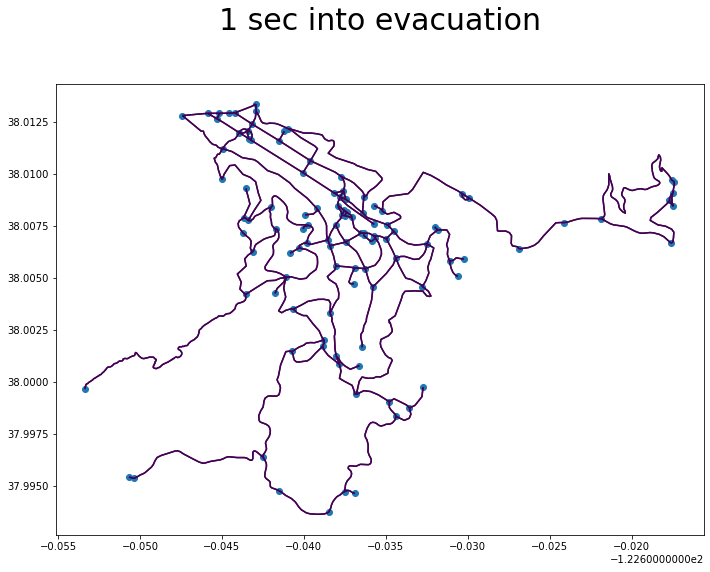

In [39]:
make_img(t=1)

In [35]:
def Cumulative(lists):
    length = len(lists)
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
#     print(cu_list[1:])
    return cu_list[1:]

[261, 322, 323, 325, 328, 332, 338, 345, 353, 361, 369, 377, 385, 393, 401, 409, 417, 425, 433, 441, 449, 457, 465, 473, 481, 489, 497, 505, 513, 521, 529, 537, 545, 553, 561, 569, 577, 585, 593, 601, 609, 617, 625, 633, 641, 649, 657, 665, 673, 681, 689, 697, 705, 713, 721, 729, 738, 747, 756, 767, 779, 792, 805, 819, 833, 848, 865, 883, 901, 921, 941, 961, 982, 1005, 1030, 1056, 1084, 1114, 1145, 1177, 1209, 1242, 1275, 1308, 1343, 1380, 1418, 1456, 1496, 1537, 1579, 1623, 1667, 1713, 1760, 1808, 1856, 1904, 1952, 2001, 2051, 2101, 2152, 2204, 2257, 2312, 2368, 2424, 2481, 2538, 2597, 2657, 2717, 2779, 2841, 2903, 2967, 3031, 3096, 3162, 3229, 3297, 3365, 3434, 3505, 3577, 3649, 3721, 3794, 3868, 3942, 4017, 4092, 4168, 4246, 4325, 4405, 4486, 4567, 4648, 4730, 4813, 4897, 4982, 5068, 5155, 5243, 5332, 5423, 5514, 5606, 5698, 5790, 5884, 5979, 6076, 6174, 6273, 6373, 6474, 6577, 6682, 6788, 6894, 7000, 7106, 7213, 7321, 7430, 7539, 7649, 7760, 7872, 7984, 8096, 8208, 8322, 8437, 8553

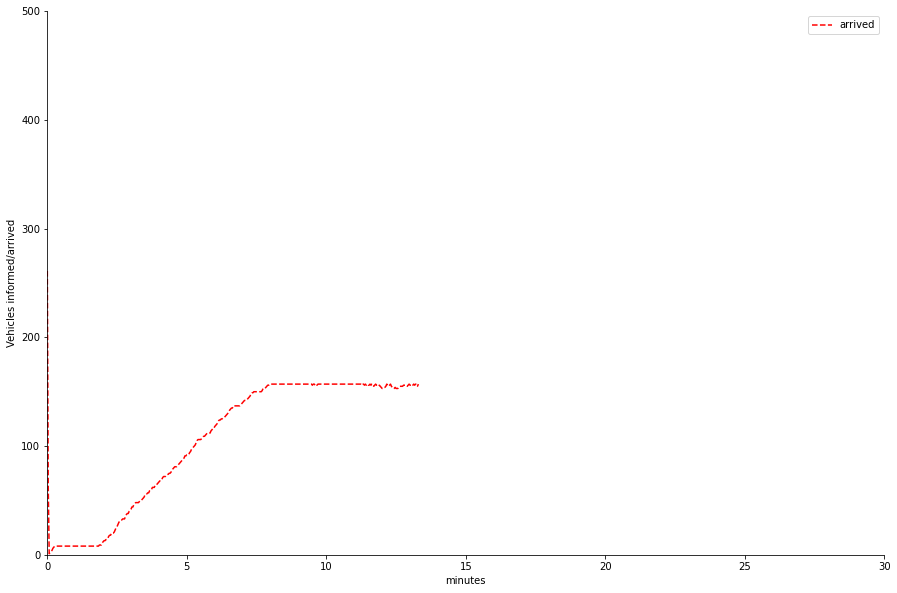

In [54]:
absolute_path = '/Users/barkha/Documents/UCB/Spring 2021/Capstone/Capstone/projects/woodacre_civic'
t_list = {}
fig, ax = plt.subplots(figsize=(15, 10))
for t in range(0, 800, 2):
    n_stats = pd.read_csv(absolute_path + '/simulation_outputs/node_stats/node_agent_cnts_test_t{}.csv'.format(t))
    # print(n_stats['node_id'])
#     print(n_stats[n_stats.node_id == 111]['cnt'])
    t_list[t] = list(n_stats[n_stats.node_id == 111]['cnt'])[0]
#     print(t_list[t] )
t_list = list(t_list.values())
t_list_total = Cumulative(t_list)
print(t_list_total)
x = list(range(0, 800, 2))
x = map(lambda m: m/60, x)
plt.plot(list(x), t_list, color='red', linestyle='--', label='arrived')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlim([0, 30])
plt.ylim([0, 500])
plt.xlabel('minutes')
plt.ylabel('Vehicles informed/arrived')
plt.legend()
#     plt.savefig(absolute_path + visualization_outputs + 'demand.png', transparent=True)
plt.show()
#     plt.close()